In [1]:
import odrive
from odrive.enums import *
import time
import numpy as np
import import_ipynb
from odrive_function import od, gait

importing Jupyter notebook from odrive_function.ipynb
importing Jupyter notebook from kinematics_function.ipynb


## Connect to Odrive

In [2]:
odrv2 = od.connect_odrive("335C315E3536")
odrv1 = od.connect_odrive("206A33A5304B")

m0  = odrv1.axis0
m1  = odrv1.axis1
m00 = odrv2.axis0
m11 = odrv2.axis1

Connected!
Target serial 335C315E3536 	 Odrive serial 56471058265398
Motor 0 calibrated: False
Motor 1 calibrated: False
Connected!
Target serial 206A33A5304B 	 Odrive serial 35640505086027
Motor 0 calibrated: False
Motor 1 calibrated: False


## Setup

In [3]:
od.SetParameter(odrv1)
od.SetParameter(odrv2)
print("Parameter Set!")

Parameter Set!


In [4]:
print("odrive1")
od.CheckMotorError(odrv1)
print("odrive2")
od.CheckMotorError(odrv2)

od.MotorClearError(odrv1)
od.MotorClearError(odrv2)
print("Error Clear!")

odrive1
error:           0 0
motorerror:      0 0
controllererror: 0 0
odrive2
error:           0 0
motorerror:      0 0
controllererror: 0 0
Error Clear!


## Motor Commands

In [5]:
od.Calibration(odrv1)
od.Calibration(odrv2)

Motor 0 calibrated: False
Motor 1 calibrated: False
Motor 0 calibrated: False
Motor 1 calibrated: False


In [6]:
od.ClosedLoopControlMode(odrv1)
od.ClosedLoopControlMode(odrv2)

In [7]:
od.IdleMode(odrv1)
od.IdleMode(odrv2)

# Define zero angle (Joint space)

In [20]:
m0_home_pos = od.SetMotorHomePosition(m0, m1)[0]
m1_home_pos = od.SetMotorHomePosition(m0, m1)[1]
print("Odrv1 \nR:", m0_home_pos, "\nL:", m1_home_pos)

Odrv1 
R: -10987.390625 
L: 2748.75


In [19]:
m00_home_pos = od.SetMotorHomePosition(m00, m11)[0]
m11_home_pos = od.SetMotorHomePosition(m00, m11)[1]
print("Odrv2 \nR:", m00_home_pos, "\nL:", m11_home_pos)

Odrv2 
R: -2361.25 
L: 1744.90625


# Define tiptoe home location (Joint space)

In [10]:
#odrv1
theta_R_eq_d = od.SetMotorEquilibriumPosition(m0, m1, m0_home_pos, m1_home_pos)[0]
theta_L_eq_d = od.SetMotorEquilibriumPosition(m0, m1, m0_home_pos, m1_home_pos)[1]
print("Odrv1 \nR:", theta_R_eq_d, "\nL:", theta_L_eq_d)

Odrv1 
R: 140.8673858642578 
L: 44.49394226074219


In [11]:
#odrv2
theta_R_eq_d = od.SetMotorEquilibriumPosition(m00, m11, m00_home_pos, m11_home_pos)[0]
theta_L_eq_d = od.SetMotorEquilibriumPosition(m00, m11, m00_home_pos, m11_home_pos)[1]
print("Odrv2 \nR:", theta_R_eq_d, "\nL:", theta_L_eq_d)

Odrv2 
R: 145.8544921875 
L: 38.50776672363282


## Gait geometry

In [13]:
UA, DA, SL = 0.05 ,0.02, 0.10 # UpperAMP, DownAMP, StepLength, StanceHeight = 0.18

## Test run (Positional Control)

In [ ]:
%matplotlib inline

In [14]:
gait.get_ready_pos(UA, DA, SL, odrv1, odrv2, m0, m1, m00, m11, m0_home_pos, m1_home_pos, m00_home_pos, m11_home_pos)

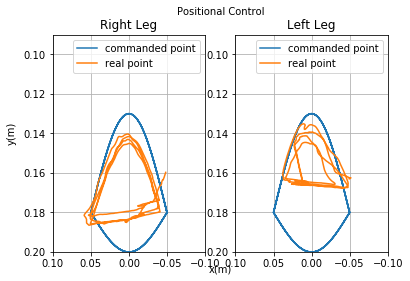

time spent:8.263537406921387sec


In [15]:
# Run test-------------------------------------------------------------
phase_t = 1 
t0 = time.time()

od.ControllerCurrentControl(odrv1)
od.ControllerCurrentControl(odrv2)

#(test_cycle, swing_time, stance_time)
gait.run_positional_step_test(4, phase_t, phase_t, UA, DA, SL, odrv1, odrv2, m0, m1, m00, m11, m0_home_pos, m1_home_pos, m00_home_pos, m11_home_pos) 

print("time spent:{}sec".format(time.time() - t0))

In [ ]:
od.IdleMode(odrv1)
od.IdleMode(odrv2)

## Test Run (Virtual Compliance)

In [21]:
UA, DA, SL = 0.04 ,0.02, 0.10 # UpperAMP, DownAMP, StepLength, StanceHeight = 0.18

In [30]:
gait.get_ready_pos(UA, DA, SL, odrv1, odrv2, m0, m1, m00, m11, m0_home_pos, m1_home_pos, m00_home_pos, m11_home_pos)

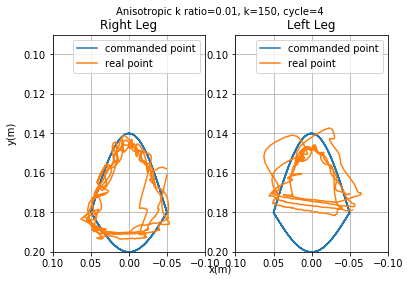

time spent:8.21041989326477sec


In [31]:
# Run test-------------------------------------------------------------
k = 1
sr = 0.01
cgr = 0.5
phase_t = 1 
t0 = time.time()

od.ControllerCurrentControl(odrv1)
od.ControllerCurrentControl(odrv2)

#(test_cycle, k_val, swing_t, stance_t, stiff_ratio, current_grid_ratio, kill_rear_motor)
gait.run_aniso_compliance_step_test(4,150, phase_t, phase_t, sr, cgr, k, UA, DA, SL, odrv1, odrv2, m0, m1, m00, m11, m0_home_pos, m1_home_pos, m00_home_pos, m11_home_pos) 

print("time spent:{}sec".format(time.time() - t0))

In [ ]:
od.IdleMode(odrv1)
od.IdleMode(odrv2)

In [ ]:
print("odrive1")
CheckMotorError(odrv1)
print("odrive2")
CheckMotorError(odrv2)

MotorClearError(odrv1)
MotorClearError(odrv2)
print("Error Clear!")

In [ ]:
ControllerPositionControl(odrv1)
ControllerPositionControl(odrv2)

In [ ]:
ClosedLoopControlMode(odrv1)
ClosedLoopControlMode(odrv2)